In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# New Section

In [ ]:

def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "partial_mask":
        return 2
    elif obj.find('name').text=="without_mask":
      return 3
    return 0

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([image_id])
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target


In [ ]:
imgs = list(sorted(os.listdir("/content/drive/My Drive/archive/images/")))

In [ ]:
labels = list(sorted(os.listdir("/content/drive/My Drive/archive/annotations/")))

In [ ]:
class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir("/content/drive/My Drive/archive/images/")))
#         self.labels = list(sorted(os.listdir("/content/drive/My Drive/archive/annotations/")))

    def __getitem__(self, idx):
        # load images ad masks
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join("/content/drive/My Drive/archive/images/", file_image)
        label_path = os.path.join("/content/drive/My Drive/archive/annotations/", file_label)
        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
data_transform = transforms.Compose([
        transforms.ToTensor(), 
    ])

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform)
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=4, collate_fn=collate_fn)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
model = get_model_instance_segmentation(4)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

[{'boxes': tensor([[ 79., 105., 109., 142.],
        [185., 100., 226., 144.],
        [325.,  90., 360., 141.]], device='cuda:0'), 'labels': tensor([3, 1, 3], device='cuda:0'), 'image_id': tensor([0], device='cuda:0')}, {'boxes': tensor([[321.,  34., 354.,  69.],
        [224.,  38., 261.,  73.],
        [299.,  58., 315.,  81.],
        [143.,  74., 174., 115.],
        [ 74.,  69.,  95.,  99.],
        [191.,  67., 221.,  93.],
        [ 21.,  73.,  44.,  93.],
        [369.,  70., 398.,  99.],
        [ 83.,  56., 111.,  89.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 3], device='cuda:0'), 'image_id': tensor([1], device='cuda:0')}, {'boxes': tensor([[ 68.,  42., 105.,  69.],
        [154.,  47., 178.,  74.],
        [238.,  34., 262.,  69.],
        [333.,  31., 366.,  65.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 2], device='cuda:0'), 'image_id': tensor([2], device='cuda:0')}, {'boxes': tensor([[ 52.,  53.,  73.,  76.],
        [ 72.,  53.,  92.,  75.],
  

In [ ]:

num_epochs = 25

model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)
PATH="/content/drive/My Drive/Tempnpic/"

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        epoch_loss += losses
    if(epoch%4==0):
        PATH=PATH+str(epoch)
        torch.save(model, PATH+"pt")

    print(epoch_loss)


Streaming output truncated to the last 5000 lines.
Iteration: 161/214, Loss: 0.43228742480278015
Iteration: 162/214, Loss: 0.05288168787956238
Iteration: 163/214, Loss: 0.18573182821273804
Iteration: 164/214, Loss: 0.05636563152074814
Iteration: 165/214, Loss: 0.42751145362854004
Iteration: 166/214, Loss: 0.09459266066551208
Iteration: 167/214, Loss: 0.07877250760793686
Iteration: 168/214, Loss: 0.05127127468585968
Iteration: 169/214, Loss: 0.5062420964241028
Iteration: 170/214, Loss: 0.38059940934181213
Iteration: 171/214, Loss: 0.6233273148536682
Iteration: 172/214, Loss: 0.3418775498867035
Iteration: 173/214, Loss: 0.11690282821655273
Iteration: 174/214, Loss: 0.0931893140077591
Iteration: 175/214, Loss: 0.5100722908973694
Iteration: 176/214, Loss: 0.10054940730333328
Iteration: 177/214, Loss: 0.2717382311820984
Iteration: 178/214, Loss: 0.12160123884677887
Iteration: 179/214, Loss: 0.06298374384641647
Iteration: 180/214, Loss: 0.04633687064051628
Iteration: 181/214, Loss: 0.2854761

In [ ]:
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

In [ ]:
model.eval()
preds = model(imgs)
preds

[{'boxes': tensor([[326.2878,  88.4649, 359.0414, 140.6425],
          [ 78.5881, 104.2124, 108.9081, 141.0740],
          [186.1359,  98.8597, 225.0400, 143.7876]], device='cuda:0',
         grad_fn=<StackBackward>),
  'labels': tensor([3, 3, 1], device='cuda:0'),
  'scores': tensor([0.9988, 0.9980, 0.9950], device='cuda:0', grad_fn=<IndexBackward>)},
 {'boxes': tensor([[ 80.4605,  54.5439, 111.4117,  89.1622],
          [224.0429,  35.4407, 259.2433,  74.0721],
          [318.6851,  34.4072, 351.7787,  70.0973],
          [141.0537,  75.7648, 172.1800, 111.8893],
          [193.4017,  65.4053, 215.5682,  92.8820],
          [ 21.1591,  71.8686,  42.0933,  93.1118],
          [298.4613,  58.6164, 312.5065,  80.0882],
          [368.4840,  68.8824, 393.0238,  94.1562],
          [368.5425,  70.7783, 389.0795,  97.2533],
          [368.5023,  70.2634, 392.1079,  93.9871],
          [152.4986,  40.9173, 178.5759,  70.0528],
          [319.2644,  33.2860, 353.6463,  63.5906],
          [1

In [ ]:
def plot_image(img_tensor, annotation):
    
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

Prediction


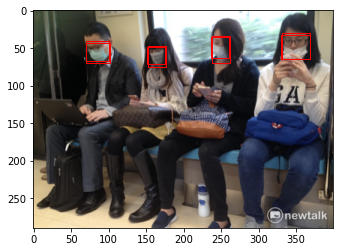

Target


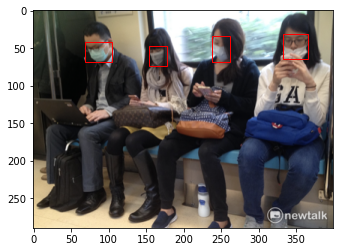

In [ ]:
print("Prediction")
plot_image(imgs[2], preds[2])
print("Target")
plot_image(imgs[2], annotations[2])

In [ ]:
torch.save(model.state_dict(),'model.pt')

In [ ]:
model2 = get_model_instance_segmentation(3)

In [ ]:
model2.load_state_dict(torch.load('model.pt'))
model2.eval()
model2.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [ ]:
pred2 =(imgs)

In [ ]:
print("Predict with loaded model")
plot_image(imgs[3], pred2[3])

Predict with loaded model


TypeError: ignored